# Continous Frugal Flows

In this notebook we demonstrate the ability for Frugal Flows to identify Marginal Causal Effects

In [1]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import KFold
from tqdm import tqdm

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
from data.analysis.validationMethods import matchit
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
from rpy2.robjects.vectors import StrVector

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

jax.config.update("jax_enable_x64", True)

hyperparams_dict = {
    'learning_rate': 5e-3,
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 50,
    'nn_depth': 4,    
    'max_patience': 100,
    'max_epochs': 10000
}
causal_hyperparams = {
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 50,
    'nn_depth': 4,   
}

SEED = 0
NUM_ITER = 25
NUM_SAMPLES = 25000
TRUE_PARAMS = {'ate': 1, 'const': 0, 'scale': 1}
CAUSAL_PARAMS = [2, 5]

In [2]:
def run_outcome_regression(data):
    Z_cont = data.get('Z_cont', None)
    Z_disc = data.get('Z_disc', None)
    if Z_cont == None:
        Z_full = Z_disc
    elif Z_disc == None:
        Z_full = Z_cont
    else:
        Z_full = jnp.hstack([Z_cont, Z_disc])
    Z_cols = [f"Z{i+1}" for i in range(Z_full.shape[1])]
    df = pd.DataFrame(jnp.hstack([data['Y'], data['X'], Z_full]), columns=['Y', 'X', *Z_cols])
    X_vars = df[['X', *Z_cols]]
    X_vars = sm.add_constant(X_vars)
    Y_var = df['Y']
    model = sm.OLS(Y_var, X_vars).fit()
    coefficient_X = model.params['X']
    coefficient_const = model.params['const']
    return coefficient_X, coefficient_const

In [3]:
def dict_to_dataframe(data):
    # Extract the data from the dictionary
    X = np.array(data['X']).flatten()
    Y = np.array(data['Y']).flatten()
    
    # Initialize a dictionary to construct the DataFrame
    df_dict = {'X': X, 'Y': Y}
    
    # Initialize the Z column index
    z_index = 1
    
    # Process Z_cont
    if 'Z_cont' in data and data['Z_cont'] is not None:
        Z_cont = np.array(data['Z_cont'])
        for i in range(Z_cont.shape[1]):
            df_dict[f'Z{z_index}'] = Z_cont[:, i]
            z_index += 1
    
    # Process Z_disc (assuming similar structure if it were present)
    if 'Z_disc' in data and data['Z_disc'] is not None:
        Z_disc = np.array(data['Z_disc'])
        for i in range(Z_disc.shape[1]):
            df_dict[f'Z{z_index}'] = Z_disc[:, i]
            z_index += 1
    
    # Create the DataFrame
    df = pd.DataFrame(df_dict)
    
    return df

In [4]:
data = causl_py.generate_mixed_samples(10000, CAUSAL_PARAMS, 3)
run_outcome_regression(data)

(5.317079641118621, 1.010870687858447)

## Checking for the Causal Effect

### Gaussians

#### Frugal Flow

In [5]:
# gaussian_covariates_results = causl_py.run_simulations(
#     causl_py.generate_gaussian_samples, 
#     seed=SEED, 
#     num_samples=NUM_SAMPLES, 
#     num_iter=NUM_ITER, 
#     causal_params=CAUSAL_PARAMS,
#     hyperparams_dict=hyperparams_dict,
#     causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
# )
# gaussian_covariates_results

In [6]:
# display(gaussian_covariates_results.mean())
# display(gaussian_covariates_results.std())

In [7]:
# plt.figure(figsize=(12, 6))

# # Boxplot
# box = gaussian_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# # Adding lines for the true parameters
# plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
# plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
# plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# # Adding title and labels
# plt.title('Box and Whisker Plot for ATE, Const, and Scale')
# plt.ylabel('Values')
# plt.ylim([0.80, 1.20])
# plt.legend()

#### Outcome Regression

In [8]:
# gaussian_coeffs = {'ate': [], 'const': []}
# for i in range(NUM_ITER):
#     data = causl_py.generate_gaussian_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
#     coeff_X, coeff_const = run_outcome_regression(data)
#     gaussian_coeffs['ate'].append(coeff_X)
#     gaussian_coeffs['const'].append(coeff_const)
# gaussian_outcome_coeffs = pd.DataFrame.from_dict(gaussian_coeffs)
# gaussian_outcome_coeffs

In [9]:
# print(gaussian_outcome_coeffs.mean())
# print(gaussian_outcome_coeffs.std())

### Mixed Gaussian and Gamma Outcomes

In [10]:
N_test = 20000
Z_disc, Z_cont, X, Y = causl_py.generate_mixed_samples(N_test, CAUSAL_PARAMS, N_test).values()

In [11]:
uz_samples = causl_py.generate_uz_samples(Z_cont=Z_cont, Z_disc=None, use_marginal_flow=False, seed=0, frugal_flow_hyperparams=hyperparams_dict)

In [12]:
frugal_flow, losses = causl_py.train_frugal_flow(
    key=jr.PRNGKey(0),
    y=Y,
    u_z=uz_samples['uz_samples'],
    # u_z = jr.uniform(jr.PRNGKey(1000), shape=(N_test, 4)),
    condition=X,
    **hyperparams_dict,
    causal_model='gaussian',
    causal_model_args={'ate': jnp.array([-7.]), 'const': 3., 'scale': 5}
)

  1%|█▎                                                                                              | 141/10000 [02:23<2:46:44,  1.01s/it, train=1.0968159477352808, val=1.1846214418748051 (Max patience reached)]


In [13]:
run_outcome_regression({'X': X, 'Y': Y, 'Z_cont': Z_cont})

(5.335628360813092, 0.9781561481863036)

In [14]:
causal_margin = frugal_flow.bijection.bijections[-1].bijection.bijections[0]

In [15]:
print(causal_margin.ate[0])
print(causal_margin.const)
print(causal_margin.scale)

4.925269243681322
2.128963814412229
0.9969615108043511


In [16]:
continous_covariates_results = causl_py.run_simulations(
    causl_py.generate_mixed_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': jnp.array([0.]), 'const': 0., 'scale': 1}
)

  2%|█▌                                                                                              | 166/10000 [03:32<3:30:07,  1.28s/it, train=1.0921668692433022, val=1.1456594916699145 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533])]


  2%|█▉                                                                                               | 196/10000 [03:58<3:18:40,  1.22s/it, train=1.109576874338564, val=1.1250401084893857 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362])]


  2%|█▊                                                                                              | 186/10000 [04:42<4:08:14,  1.52s/it, train=1.0978622307346864, val=1.1226743478311152 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795])]


  2%|█▉                                                                                              | 203/10000 [05:21<4:18:57,  1.59s/it, train=1.1000625233787247, val=1.1519495062335467 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629])]


  1%|█▎                                                                                              | 133/10000 [03:18<4:05:03,  1.49s/it, train=1.1129295054778896, val=1.1315532330802218 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776])]


  2%|█▊                                                                                              | 190/10000 [05:36<4:49:13,  1.77s/it, train=1.0922187547794373, val=1.1529824781819087 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096])]


  2%|█▌                                                                                              | 165/10000 [04:21<4:20:04,  1.59s/it, train=1.1013171427788495, val=1.1840653150001033 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699])]


  1%|█▎                                                                                               | 137/10000 [03:24<4:04:53,  1.49s/it, train=1.105639563588559, val=1.1190025343343581 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539])]


  2%|█▌                                                                                              | 168/10000 [04:22<4:15:45,  1.56s/it, train=1.0917934962088216, val=1.1496913419706971 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976])]


  2%|█▍                                                                                              | 152/10000 [03:47<4:05:25,  1.50s/it, train=1.1089807657912683, val=1.1697257790864761 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ])]


  2%|█▋                                                                                              | 171/10000 [04:18<4:07:57,  1.51s/it, train=1.1144428094955137, val=1.1603396898547005 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ])]


  2%|█▉                                                                                               | 203/10000 [05:06<4:06:13,  1.51s/it, train=1.114862870449965, val=1.1185718119884607 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243])]


  2%|█▌                                                                                               | 157/10000 [03:58<4:09:15,  1.52s/it, train=1.103590096052073, val=1.1638914911865939 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431])]


  2%|█▋                                                                                              | 179/10000 [04:15<3:53:20,  1.43s/it, train=1.1011828593468118, val=1.2010552329779136 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176])]


  2%|██▎                                                                                             | 247/10000 [06:20<4:10:36,  1.54s/it, train=1.1054194201555028, val=1.1365500978507197 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269])]


  1%|█▎                                                                                               | 138/10000 [03:22<4:00:51,  1.47s/it, train=1.1056423909892863, val=1.159123124045874 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731])]


  1%|█▎                                                                                              | 139/10000 [03:37<4:16:43,  1.56s/it, train=1.1071317635880418, val=1.1437332670090028 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731]), array([4.92130801, 2.09764329, 1.01822801])]


  2%|█▍                                                                                              | 150/10000 [04:08<4:32:00,  1.66s/it, train=1.1127719877191544, val=1.1202583328346336 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731]), array([4.92130801, 2.09764329, 1.01822801]), array([5.03775774, 1.95696666, 1.01592807])]


  2%|█▋                                                                                              | 172/10000 [03:57<3:46:30,  1.38s/it, train=1.1728465202711829, val=1.2264511795443236 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731]), array([4.92130801, 2.09764329, 1.01822801]), array([5.03775774, 1.95696666, 1.01592807]), array([5.44866267, 1.59823576, 1.01250167])]


  2%|█▋                                                                                              | 176/10000 [04:28<4:09:52,  1.53s/it, train=1.1041860296503185, val=1.1717507492523391 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731]), array([4.92130801, 2.09764329, 1.01822801]), array([5.03775774, 1.95696666, 1.01592807]), array([5.44866267, 1.59823576, 1.01250167]), array([5.02889377, 1.97506004, 1.00843964])]


  2%|██                                                                                              | 220/10000 [05:37<4:09:49,  1.53s/it, train=1.1111581432694368, val=1.1595073246257823 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731]), array([4.92130801, 2.09764329, 1.01822801]), array([5.03775774, 1.95696666, 1.01592807]), array([5.44866267, 1.59823576, 1.01250167]), array([5.02889377, 1.97506004, 1.00843964]), array([5.0251026 , 1.96328776, 1.02638699])]


  1%|█▏                                                                                              | 129/10000 [03:12<4:05:10,  1.49s/it, train=1.1109306768133094, val=1.1746077768811194 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731]), array([4.92130801, 2.09764329, 1.01822801]), array([5.03775774, 1.95696666, 1.01592807]), array([5.44866267, 1.59823576, 1.01250167]), array([5.02889377, 1.97506004, 1.00843964]), array([5.0251026 , 1.96328776, 1.02638699]), array([4.7281814 , 2.24963927, 1.0086924 ])]


  2%|██                                                                                              | 211/10000 [05:14<4:02:49,  1.49s/it, train=1.0933196286432525, val=1.1314556200670303 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731]), array([4.92130801, 2.09764329, 1.01822801]), array([5.03775774, 1.95696666, 1.01592807]), array([5.44866267, 1.59823576, 1.01250167]), array([5.02889377, 1.97506004, 1.00843964]), array([5.0251026 , 1.96328776, 1.02638699]), array([4.7281814 , 2.24963927, 1.0086924 ]), array([5.

  1%|█▎                                                                                              | 131/10000 [03:26<4:19:24,  1.58s/it, train=1.0985319837332683, val=1.1442629046265131 (Max patience reached)]


[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731]), array([4.92130801, 2.09764329, 1.01822801]), array([5.03775774, 1.95696666, 1.01592807]), array([5.44866267, 1.59823576, 1.01250167]), array([5.02889377, 1.97506004, 1.00843964]), array([5.0251026 , 1.96328776, 1.02638699]), array([4.7281814 , 2.24963927, 1.0086924 ]), array([5.

  2%|█▋                                                                                               | 169/10000 [04:12<4:04:37,  1.49s/it, train=1.111168350376031, val=1.1258316311184267 (Max patience reached)]

[array([4.98728548, 1.9944611 , 0.97481533]), array([5.07405115, 1.96035884, 0.99112362]), array([5.01220846, 2.00065041, 1.00869795]), array([4.99828329, 1.9918387 , 1.00329629]), array([4.86189775, 2.1268459 , 1.00258776]), array([5.06351153, 1.95819267, 1.01740096]), array([4.93784821, 2.07511204, 0.97805699]), array([4.96942418, 2.03732827, 1.00797539]), array([5.05672197, 1.94181214, 0.99080976]), array([5.02657153, 1.98074843, 1.0164012 ]), array([4.99751496, 2.02216643, 1.0052117 ]), array([4.96669541, 2.02340077, 0.99965243]), array([5.01128701, 1.99080635, 0.99201431]), array([5.05007901, 1.92766443, 1.00460176]), array([5.04308064, 1.98691104, 0.99255269]), array([4.98283539, 2.02204803, 1.01372731]), array([4.92130801, 2.09764329, 1.01822801]), array([5.03775774, 1.95696666, 1.01592807]), array([5.44866267, 1.59823576, 1.01250167]), array([5.02889377, 1.97506004, 1.00843964]), array([5.0251026 , 1.96328776, 1.02638699]), array([4.7281814 , 2.24963927, 1.0086924 ]), array([5.

In [17]:
print(continous_covariates_results.mean())
print(continous_covariates_results.std())

ate      5.003966
const    1.999094
scale    1.004035
dtype: float64
ate      0.121473
const    0.110376
scale    0.012235
dtype: float64


In [18]:
matchit_ate_list = []
for i in tqdm(range(NUM_ITER)):
    data = causl_py.generate_mixed_samples(20000, CAUSAL_PARAMS, i)
    matching_results = matchit(outcome='Y', treatment='X', data=dict_to_dataframe(data))
    matchit_ate_list.append(matching_results[0][0])
print(np.mean(matchit_ate_list))
print(np.std(matchit_ate_list))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [35:37<00:00, 85.49s/it]

4.679878065794852
0.5839430759273976


In [19]:
print(np.mean(matchit_ate_list))
print(np.std(matchit_ate_list))

4.679878065794852
0.5839430759273976


#### Outcome Regression

In [20]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_mixed_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,5.299270,1.002483
1,5.293492,0.997527
2,5.283894,1.003643
3,5.277860,1.019234
4,5.290454,0.980813
5,5.349729,0.958014
6,5.221412,1.071590
7,5.326167,0.992009
8,5.313750,1.001159
9,5.272994,1.008471


In [21]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      5.292286
const    1.008846
dtype: float64
ate      0.024892
const    0.023614
dtype: float64


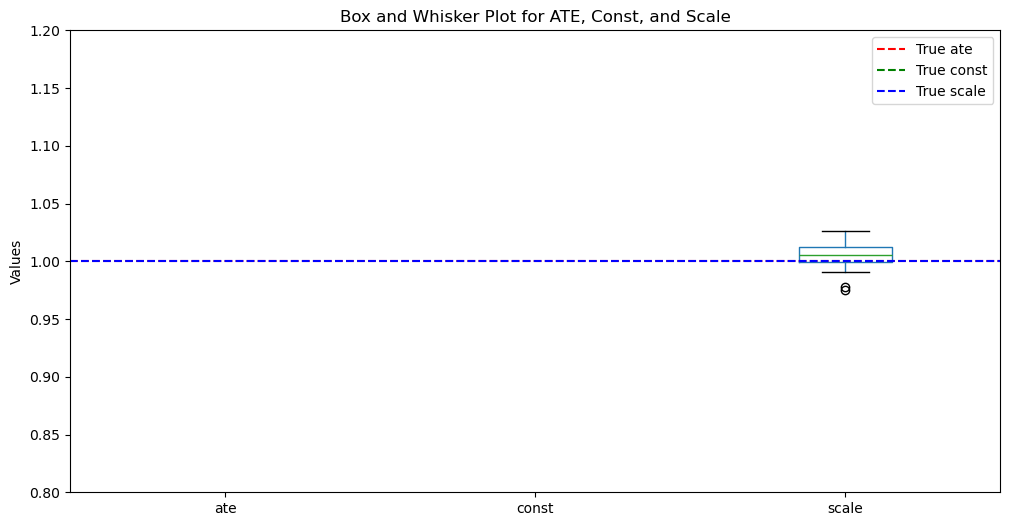

In [22]:
plt.figure(figsize=(12, 6))

# Boxplot
box = continous_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Small)

In [23]:
discrete_small_covariates_results = causl_py.run_simulations(
    causl_py.generate_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': jnp.array([0.]), 'const': 0., 'scale': 1}
)

  3%|██▋                                                                                               | 269/10000 [06:22<3:50:47,  1.42s/it, train=1.1173492277071226, val=1.1338175542128297 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435])]


  2%|██▎                                                                                               | 241/10000 [06:46<4:34:34,  1.69s/it, train=1.1172337419768428, val=1.1510210889965693 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278])]


  2%|██▎                                                                                                 | 225/10000 [05:49<4:13:10,  1.55s/it, train=1.127173779736355, val=1.150252366943146 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824])]


  2%|██▏                                                                                               | 217/10000 [04:44<3:33:30,  1.31s/it, train=1.1427709494604483, val=1.1631986247370412 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906])]


  3%|██▊                                                                                                | 282/10000 [07:42<4:25:40,  1.64s/it, train=1.122600841842617, val=1.1694049995301012 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123])]


  2%|█▊                                                                                                 | 179/10000 [04:47<4:22:40,  1.60s/it, train=1.1211476825237099, val=1.140278044253776 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849])]


  2%|█▋                                                                                                | 177/10000 [04:19<3:59:41,  1.46s/it, train=1.1188936327631533, val=1.1691804101502246 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707])]


  2%|█▌                                                                                                | 157/10000 [04:15<4:27:28,  1.63s/it, train=1.1203257639205275, val=1.1634415816006223 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248])]


  2%|█▌                                                                                                | 164/10000 [03:57<3:57:47,  1.45s/it, train=1.1209123733876862, val=1.1182989939625236 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ])]


  2%|██▏                                                                                                | 218/10000 [06:14<4:40:01,  1.72s/it, train=1.129415114163073, val=1.1422729679257466 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422])]


  2%|█▊                                                                                                | 190/10000 [05:05<4:22:34,  1.61s/it, train=1.1255574070268313, val=1.1443685823886411 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ])]


  1%|█▎                                                                                                | 136/10000 [03:28<4:11:52,  1.53s/it, train=1.1151966612799131, val=1.1319956260492976 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ])]


  2%|██                                                                                                | 208/10000 [04:19<3:23:53,  1.25s/it, train=1.1211805822895993, val=1.1723634348421539 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072])]


  1%|█▍                                                                                                | 143/10000 [03:25<3:56:37,  1.44s/it, train=1.1224374455909518, val=1.1080682503116537 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485])]


  2%|██▎                                                                                               | 231/10000 [06:28<4:33:43,  1.68s/it, train=1.1311656990534362, val=1.1595743365301536 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959])]


  2%|██                                                                                                | 209/10000 [04:52<3:48:02,  1.40s/it, train=1.1137696964427333, val=1.1397750998936664 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441])]


  2%|█▋                                                                                                 | 165/10000 [03:53<3:52:23,  1.42s/it, train=1.105876825369105, val=1.1573023063433419 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441]), array([5.02300892, 1.97021304, 0.89461032])]


  2%|██▍                                                                                               | 250/10000 [06:49<4:26:29,  1.64s/it, train=1.1239709130950748, val=1.1274504956464562 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441]), array([5.02300892, 1.97021304, 0.89461032]), array([5.04542937, 1.95295033, 0.8847066 ])]


  3%|██▋                                                                                               | 279/10000 [06:51<3:59:13,  1.48s/it, train=1.1460097319425477, val=1.1547696723454415 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441]), array([5.02300892, 1.97021304, 0.89461032]), array([5.04542937, 1.95295033, 0.8847066 ]), array([5.18059332, 1.82238582, 0.90447937])]


  3%|██▋                                                                                               | 277/10000 [07:23<4:19:25,  1.60s/it, train=1.1190431567964183, val=1.1687434843428648 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441]), array([5.02300892, 1.97021304, 0.89461032]), array([5.04542937, 1.95295033, 0.8847066 ]), array([5.18059332, 1.82238582, 0.90447937]), array([5.01542776, 1.99522127, 0.91984684])]


  2%|██▎                                                                                               | 230/10000 [05:02<3:34:18,  1.32s/it, train=1.1117015455772536, val=1.1332520774897221 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441]), array([5.02300892, 1.97021304, 0.89461032]), array([5.04542937, 1.95295033, 0.8847066 ]), array([5.18059332, 1.82238582, 0.90447937]), array([5.01542776, 1.99522127, 0.91984684]), array([4.98501612, 2.02273628, 0.8907904 ])]


  1%|█▏                                                                                                | 127/10000 [02:43<3:31:40,  1.29s/it, train=1.1320701561929007, val=1.1423387740938438 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441]), array([5.02300892, 1.97021304, 0.89461032]), array([5.04542937, 1.95295033, 0.8847066 ]), array([5.18059332, 1.82238582, 0.90447937]), array([5.01542776, 1.99522127, 0.91984684]), array([4.98501612, 2.02273628, 0.8907904 ]), array([4.68685212, 2.32392547, 0.92281043])]


  3%|███                                                                                               | 313/10000 [07:29<3:51:58,  1.44s/it, train=1.1223499422428604, val=1.1272441773768507 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441]), array([5.02300892, 1.97021304, 0.89461032]), array([5.04542937, 1.95295033, 0.8847066 ]), array([5.18059332, 1.82238582, 0.90447937]), array([5.01542776, 1.99522127, 0.91984684]), array([4.98501612, 2.02273628, 0.8907904 ]), array([4.68685212, 2.32392547, 0.92281043]), array([5.

  2%|█▉                                                                                                 | 194/10000 [03:58<3:21:04,  1.23s/it, train=1.122364891275984, val=1.1324314755937968 (Max patience reached)]


[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441]), array([5.02300892, 1.97021304, 0.89461032]), array([5.04542937, 1.95295033, 0.8847066 ]), array([5.18059332, 1.82238582, 0.90447937]), array([5.01542776, 1.99522127, 0.91984684]), array([4.98501612, 2.02273628, 0.8907904 ]), array([4.68685212, 2.32392547, 0.92281043]), array([5.

  1%|█▎                                                                                                | 135/10000 [03:03<3:44:04,  1.36s/it, train=1.1267194740244806, val=1.1438399301809667 (Max patience reached)]

[array([5.02781703, 1.98270589, 0.91683435]), array([5.02004725, 1.96263199, 0.88661278]), array([5.00259683, 2.01461911, 0.90119824]), array([5.18989756, 1.8290325 , 0.91027906]), array([5.07463534, 1.9194478 , 0.90019123]), array([5.00495506, 1.97940062, 0.88960849]), array([4.99094294, 2.02884691, 0.91058707]), array([4.99190506, 2.01987111, 0.89205248]), array([5.04951274, 1.9542658 , 0.889241  ]), array([4.9817213 , 2.01689509, 0.92666422]), array([5.04753932, 1.94784968, 0.9029425 ]), array([4.92899695, 2.10133325, 0.8909806 ]), array([5.0505322 , 1.95311328, 0.89654072]), array([4.96401131, 2.05784143, 0.87522485]), array([5.02590987, 2.00332349, 0.90609959]), array([5.06614762, 1.94456051, 0.89594441]), array([5.02300892, 1.97021304, 0.89461032]), array([5.04542937, 1.95295033, 0.8847066 ]), array([5.18059332, 1.82238582, 0.90447937]), array([5.01542776, 1.99522127, 0.91984684]), array([4.98501612, 2.02273628, 0.8907904 ]), array([4.68685212, 2.32392547, 0.92281043]), array([5.

In [24]:
discrete_small_covariates_results

,ate,const,scale
0,5.027817,1.982706,0.916834
1,5.020047,1.962632,0.886613
2,5.002597,2.014619,0.901198
3,5.189898,1.829032,0.910279
4,5.074635,1.919448,0.900191
5,5.004955,1.979401,0.889608
6,4.990943,2.028847,0.910587
7,4.991905,2.019871,0.892052
8,5.049513,1.954266,0.889241
9,4.981721,2.016895,0.926664


In [25]:
print(discrete_small_covariates_results.mean())
print(discrete_small_covariates_results.std())

ate      5.013955
const    1.990979
scale    0.900528
dtype: float64
ate      0.090443
const    0.093403
scale    0.012583
dtype: float64


In [26]:
matchit_ate_list_small_discrete = []
for i in tqdm(range(NUM_ITER)):
    data = causl_py.generate_discrete_samples(NUM_SAMPLES, CAUSAL_PARAMS, i)
    matching_results = matchit(outcome='Y', treatment='X', data=dict_to_dataframe(data))
    matchit_ate_list_small_discrete.append(matching_results[0][0])
print(np.mean(matchit_ate_list_small_discrete))
print(np.std(matchit_ate_list_small_discrete))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [34:01<00:00, 81.65s/it]

5.551075741285571
0.441494569513271


#### Outcome Regression

In [27]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,5.399200,0.962902
1,5.422402,0.955786
2,5.453248,0.926767
3,5.450133,0.936159
4,5.431033,0.944478
5,5.408030,0.969340
6,5.414103,0.962040
7,5.385137,1.005677
8,5.469458,0.916307
9,5.431259,0.929893


In [28]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      5.436735
const    0.942019
dtype: float64
ate      0.025858
const    0.024928
dtype: float64


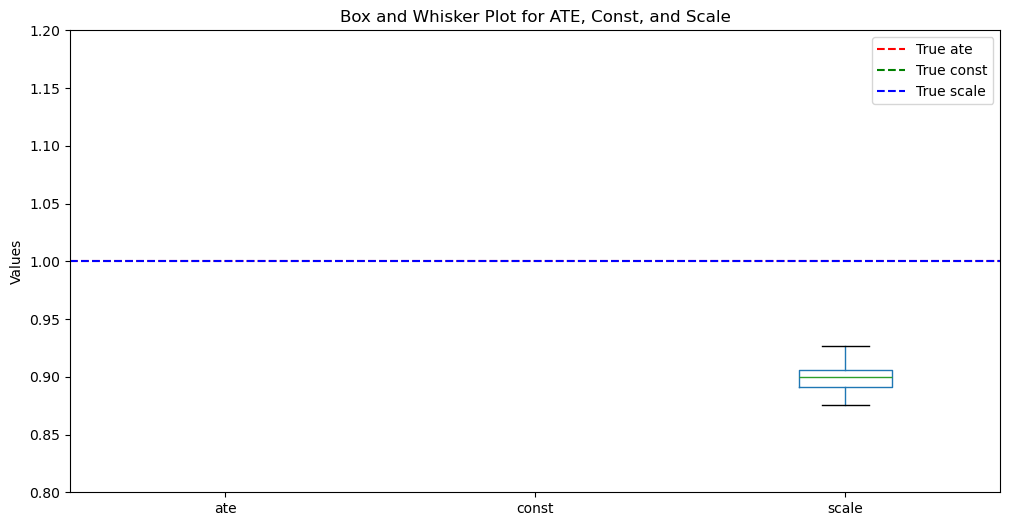

In [29]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_small_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large)

In [30]:
hyperparams_dict_large = hyperparams_dict.copy()
# hyperparams_dict_large['learning_rate'] = 1e-3
discrete_big_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict_large,
    causal_model_args={'ate': jnp.array([0.]), 'const': 0., 'scale': 1}
)

  2%|█▊                                                                                                 | 184/10000 [07:00<6:14:06,  2.29s/it, train=1.312978869510747, val=1.3914663885711838 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ])]


  2%|█▉                                                                                                   | 197/10000 [09:11<7:37:02,  2.80s/it, train=1.3285427475081, val=1.3764110687889417 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748])]


  2%|██▎                                                                                               | 239/10000 [10:11<6:56:21,  2.56s/it, train=1.2554148198650485, val=1.2849531043259057 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351])]


  2%|██▎                                                                                               | 230/10000 [08:30<6:01:43,  2.22s/it, train=1.3860604967263213, val=1.4151586963744935 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155])]


  1%|█▍                                                                                                | 146/10000 [05:19<5:59:40,  2.19s/it, train=1.2544625411416013, val=1.3178514769282543 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ])]


  2%|█▊                                                                                                  | 185/10000 [07:30<6:38:13,  2.43s/it, train=1.26975726729156, val=1.3336486093887912 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554])]


  1%|█▎                                                                                                 | 131/10000 [05:35<7:00:46,  2.56s/it, train=1.3470443411757518, val=1.390253032384598 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093])]


  2%|█▌                                                                                                | 161/10000 [06:30<6:37:41,  2.43s/it, train=1.3810991581963257, val=1.3803121720078662 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735])]


  1%|█▍                                                                                                 | 146/10000 [06:13<7:00:24,  2.56s/it, train=1.3748262898962806, val=1.391210806455206 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106])]


  2%|██▏                                                                                                | 225/10000 [09:09<6:37:39,  2.44s/it, train=1.278410440330134, val=1.3173192073554008 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547])]


  2%|█▉                                                                                                | 197/10000 [08:26<7:00:23,  2.57s/it, train=1.3387612132422155, val=1.3350911174813322 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332])]


  2%|█▋                                                                                                | 169/10000 [07:24<7:11:20,  2.63s/it, train=1.2433929469579073, val=1.3160669719737443 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ])]


  2%|██▏                                                                                                 | 218/10000 [08:36<6:25:56,  2.37s/it, train=1.376005934279066, val=1.402980123732216 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644])]


  2%|█▉                                                                                                | 196/10000 [08:01<6:41:27,  2.46s/it, train=1.3700241391059855, val=1.3607058515368937 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197])]


  1%|█▍                                                                                                  | 141/10000 [05:55<6:54:10,  2.52s/it, train=1.370422382714804, val=1.390729545716693 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ])]


  1%|█▏                                                                                                | 127/10000 [05:28<7:05:32,  2.59s/it, train=1.3739149425318191, val=1.3826171635800302 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727])]


  2%|█▊                                                                                                | 182/10000 [08:12<7:22:42,  2.71s/it, train=1.3805506958897273, val=1.3774734955926469 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727]), array([5.33738087, 1.65946826, 0.92250136])]


  2%|██▏                                                                                               | 222/10000 [08:32<6:16:33,  2.31s/it, train=1.3761495382031368, val=1.3820630160519654 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727]), array([5.33738087, 1.65946826, 0.92250136]), array([5.32556841, 1.70253849, 0.92930589])]


  2%|█▍                                                                                                | 152/10000 [06:33<7:04:59,  2.59s/it, train=1.2890882906180166, val=1.3358182561894825 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727]), array([5.33738087, 1.65946826, 0.92250136]), array([5.32556841, 1.70253849, 0.92930589]), array([5.22167226, 1.80249212, 0.92880021])]


  2%|█▊                                                                                                | 179/10000 [06:52<6:16:49,  2.30s/it, train=1.2696258822934037, val=1.3531603067007725 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727]), array([5.33738087, 1.65946826, 0.92250136]), array([5.32556841, 1.70253849, 0.92930589]), array([5.22167226, 1.80249212, 0.92880021]), array([4.93335814, 2.10827934, 0.92039002])]


  2%|██▎                                                                                                | 239/10000 [09:07<6:12:31,  2.29s/it, train=1.3726681023315297, val=1.378369372132135 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727]), array([5.33738087, 1.65946826, 0.92250136]), array([5.32556841, 1.70253849, 0.92930589]), array([5.22167226, 1.80249212, 0.92880021]), array([4.93335814, 2.10827934, 0.92039002]), array([5.28843472, 1.71716675, 0.93533623])]


  2%|██                                                                                                 | 211/10000 [08:18<6:25:16,  2.36s/it, train=1.374782861600442, val=1.3575339441598941 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727]), array([5.33738087, 1.65946826, 0.92250136]), array([5.32556841, 1.70253849, 0.92930589]), array([5.22167226, 1.80249212, 0.92880021]), array([4.93335814, 2.10827934, 0.92039002]), array([5.28843472, 1.71716675, 0.93533623]), array([5.33511497, 1.67407115, 0.92438558])]


  4%|███▌                                                                                              | 364/10000 [13:42<6:02:54,  2.26s/it, train=1.3739132867330661, val=1.3712388013646828 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727]), array([5.33738087, 1.65946826, 0.92250136]), array([5.32556841, 1.70253849, 0.92930589]), array([5.22167226, 1.80249212, 0.92880021]), array([4.93335814, 2.10827934, 0.92039002]), array([5.28843472, 1.71716675, 0.93533623]), array([5.33511497, 1.67407115, 0.92438558]), array([5.

  4%|███▌                                                                                            | 369/10000 [12:52<5:35:50,  2.09s/it, train=1.2813187499486451, val=1.3002641044456582 (Max patience reached)]


[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727]), array([5.33738087, 1.65946826, 0.92250136]), array([5.32556841, 1.70253849, 0.92930589]), array([5.22167226, 1.80249212, 0.92880021]), array([4.93335814, 2.10827934, 0.92039002]), array([5.28843472, 1.71716675, 0.93533623]), array([5.33511497, 1.67407115, 0.92438558]), array([5.

  2%|██                                                                                              | 220/10000 [07:47<5:46:17,  2.12s/it, train=1.3713513375328565, val=1.3833029549101648 (Max patience reached)]

[array([5.08720706, 1.91180953, 0.9131049 ]), array([5.2483436 , 1.76493762, 0.89583748]), array([5.07972732, 1.89393982, 0.91718351]), array([5.31477986, 1.70398745, 0.91425155]), array([4.9836888 , 2.02091286, 0.9344229 ]), array([5.02873035, 1.96887537, 0.93614554]), array([5.10711127, 1.87433458, 0.94116093]), array([5.3354858 , 1.63756214, 0.90472735]), array([5.29507711, 1.68549925, 0.92489106]), array([5.11146265, 1.89852758, 0.92898547]), array([5.03872044, 1.96652139, 0.92643332]), array([4.97160913, 2.02909952, 0.9341197 ]), array([5.34018313, 1.65760283, 0.90864644]), array([5.28177692, 1.71371249, 0.91180197]), array([5.32738193, 1.65868883, 0.9061159 ]), array([4.99221149, 2.00680725, 0.91488727]), array([5.33738087, 1.65946826, 0.92250136]), array([5.32556841, 1.70253849, 0.92930589]), array([5.22167226, 1.80249212, 0.92880021]), array([4.93335814, 2.10827934, 0.92039002]), array([5.28843472, 1.71716675, 0.93533623]), array([5.33511497, 1.67407115, 0.92438558]), array([5.

In [31]:
discrete_big_covariates_results

,ate,const,scale
0,5.087207,1.911810,0.913105
1,5.248344,1.764938,0.895837
2,5.079727,1.893940,0.917184
3,5.314780,1.703987,0.914252
4,4.983689,2.020913,0.934423
5,5.028730,1.968875,0.936146
6,5.107111,1.874335,0.941161
7,5.335486,1.637562,0.904727
8,5.295077,1.685499,0.924891
9,5.111463,1.898528,0.928985


In [32]:
print(discrete_big_covariates_results.mean())
print(discrete_big_covariates_results.std())

ate      5.182242
const    1.821038
scale    0.922466
dtype: float64
ate      0.150447
const    0.154815
scale    0.011578
dtype: float64


#### Outcome Regression

In [33]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,5.153209,1.003310
1,5.160226,0.983476
2,5.184430,1.002689
3,5.116931,1.041252
4,5.119048,1.016261
5,5.151797,0.984587
6,5.158239,0.950351
7,5.182327,0.982193
8,5.123116,1.020756
9,5.132334,0.981362


In [34]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      5.135790
const    1.013328
dtype: float64
ate      0.023648
const    0.028511
dtype: float64


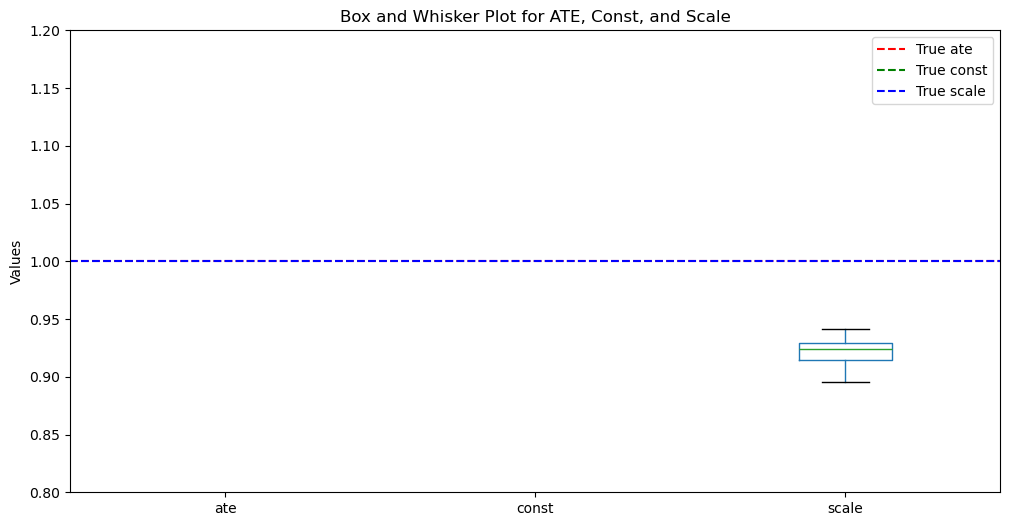

In [35]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_big_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

In [ ]:
matchit_ate_list_many_discrete = []
for i in tqdm(range(NUM_ITER)):
    data = causl_py.generate_many_discrete_samples(NUM_SAMPLES, CAUSAL_PARAMS, i)
    matching_results = matchit(outcome='Y', treatment='X', data=dict_to_dataframe(data))
    matchit_ate_list_many_discrete.append(matching_results[0][0])
print(np.mean(matchit_ate_list_many_discrete))
print(np.std(matchit_ate_list_many_discrete))

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 16/25 [28:03<15:27, 103.07s/it]

### Mixed Continuous and Discrete (Large and Sparse)

In [ ]:
# discrete_sparse_covariates_results = causl_py.run_simulations(
#     causl_py.generate_many_discrete_samples_sparse, 
#     seed=SEED, 
#     num_samples=NUM_SAMPLES, 
#     num_iter=NUM_ITER, 
#     causal_params=CAUSAL_PARAMS,
#     hyperparams_dict=hyperparams_dict,
#     causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
# )
# discrete_sparse_covariates_results

In [ ]:
# print(discrete_sparse_covariates_results.mean())
# print(discrete_sparse_covariates_results.std())

#### Outcome Regression

In [ ]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

In [ ]:
# plt.figure(figsize=(12, 6))

# # Boxplot
# box = discrete_sparse_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# # Adding lines for the true parameters
# plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
# plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
# plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# # Adding title and labels
# plt.title('Box and Whisker Plot for ATE, Const, and Scale')
# plt.ylabel('Values')
# plt.ylim([0.80, 1.20])
# plt.legend()